# Comparaison des modèles SARIMA, KNN et RF

## Basé uniquement sur la météo.

L'objectif de ce notebook est de créer un tableau comparatif.

Le modèle sarimax sera dans ce cas entrainé par nature avec les consommations des instants précédents et avec pour valeur exogène la météo utilisé par les autres modèles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


In [2]:
### Cleaning & mise en forme ###
df = pd.read_csv('clean_data/data_meteo_prod.csv', header=0, parse_dates=[0],  index_col=14,squeeze=True)
df['rafales_sur_une_periode']=df['rafales_sur_une_periode'].astype(float)
colonne_inutile =['regioncode', 'latitude', 'longitude', 'altitude',
                  'thermique_mw', 'nucleaire_mw', 'eolien_mw', 'solaire_mw',
                  'hydraulique_mw', 'pompage_mw', 'bioenergies_mw', 'ech._physiques_mw',
                  'prod_totale']
df= df.drop(colonne_inutile, axis=1)
df.index= pd.to_datetime(df.index)

# Par Mois : Entrainement des modèles

In [3]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_mois= df.resample('M').agg(function_to_apply)

data = df_mois['consommation_mw'].loc['2013-01-01':'2019-12-31']
exogene = df_mois.drop('consommation_mw', axis=1).loc['2013-01-01':'2019-12-31']

exogene = preprocessing.StandardScaler().fit_transform(exogene)
exogene = pd.DataFrame(exogene)
exogene.index = data.index

Y = df_mois['consommation_mw']
X = df_mois.drop('consommation_mw', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [4]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)   
X_test_scaled = scaler.transform(X_test)

In [5]:
rf = RandomForestRegressor (max_features='auto', 
                            min_samples_leaf=1, 
                            n_estimators=100,)     # MEILLEUR PARAMETRE PROVENANT NOTEBOOK Nested CV

knn = KNeighborsRegressor(metric= 'manhattan', 
                          n_neighbors=6, 
                          weights='distance',)       # MEILLEUR PARAMETRE PROVENANT NOTEBOOK KNN

sarimax =sm.tsa.SARIMAX(data ,exog = exogene, order=(0,1,0) ,seasonal_order = (0, 1, 1, 12)).fit()  #MEILLEUR PARAMETRE NOTEBOOK SARIMAX

In [6]:
rf.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=6, weights='distance')

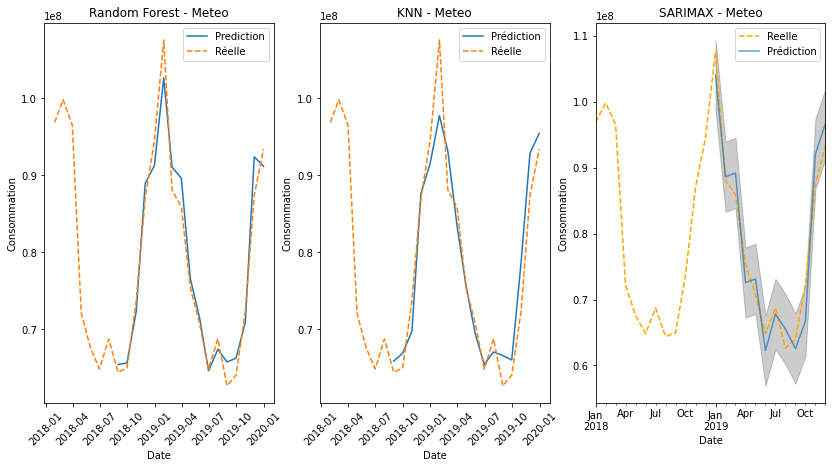

In [7]:
pred_sarima = sarimax.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_ci = pred_sarima.conf_int()
y_pred_rf = rf.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)

plt.figure(figsize=(25,25))
plt.subplot(131)
plt.plot(y_test.index, y_pred_rf, label='Prediction')
plt.title('Random Forest - Meteo')
plt.plot(Y['2018':], label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_test.index, y_pred_knn, label='Prédiction')
plt.plot(Y['2018':], label='Réelle', linestyle='dashed')
plt.title('KNN - Meteo')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = data['2018':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Meteo')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()



plt.show()

# Par Jours : Entrainement des modèles
**Nous nous limiterons à l'année 2018 - 2019 pour cette partie.**

In [8]:
function_to_apply = {
    'rafales_sur_une_periode' : 'max',
    'variation_de_pression_en_3_heures' : 'sum',
    'precipitations_dans_les_3_dernieres_heures' : 'sum',
    'pression_station' : 'mean',
    'pression_au_niveau_mer' : 'mean',
    'direction_du_vent_moyen' : 'median', #médiane de la direction sur la journée
    'vitesse_du_vent_moyen' : 'mean',
    'humidite' : 'mean',
    'point_de_rosee' : 'mean',
    'temperature_c' : 'mean',
    'consommation_mw' : 'sum',
}
df_day = df.resample('D').agg(function_to_apply)
df_day = df_day.loc['2018':]

data = df_day['consommation_mw'].loc['2018-01-01':'2019-12-31']
exogene = df_day.drop('consommation_mw', axis=1).loc['2018-01-01':'2019-12-31']

exogene = preprocessing.StandardScaler().fit_transform(exogene)
exogene = pd.DataFrame(exogene)
exogene.index = data.index

Y = df_day['consommation_mw']
X = df_day.drop('consommation_mw', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)   
X_test_scaled = scaler.transform(X_test)

In [10]:
rf = RandomForestRegressor (max_features='auto', 
                            min_samples_leaf=1, 
                            n_estimators=1000,)     # MEILLEUR PARAMETRE PROVENANT NOTEBOOK Nested CV

knn = KNeighborsRegressor(metric= 'manhattan', 
                          n_neighbors=12, 
                          weights='distance',)       # MEILLEUR PARAMETRE PROVENANT NOTEBOOK KNN

sarimax =sm.tsa.SARIMAX(data ,exog = exogene, order=(0,1,0) ,seasonal_order = (1, 1, 1, 7)).fit()  #MEILLEUR PARAMETRE NOTEBOOK SARIMAX

rf.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=12, weights='distance')

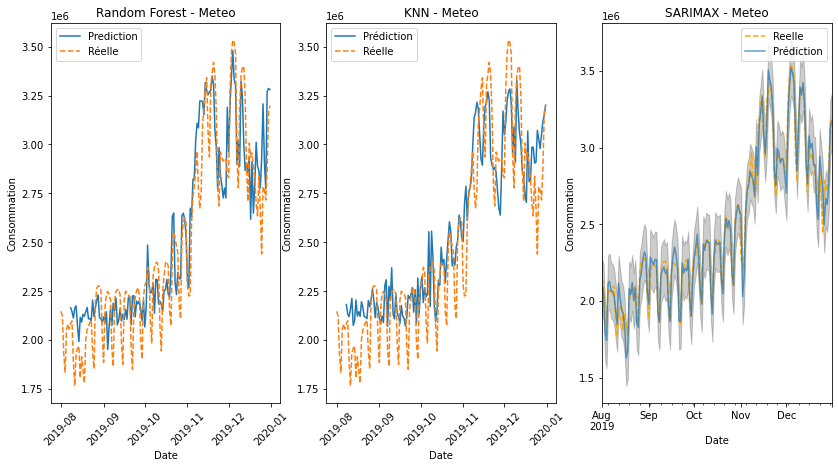

In [11]:
pred_sarima = sarimax.get_prediction(start=pd.to_datetime('2019-08-01'), dynamic=False)
pred_ci = pred_sarima.conf_int()

y_pred_rf = rf.predict(X_test_scaled)

y_pred_knn = knn.predict(X_test_scaled)

plt.figure(figsize=(25,25))
plt.subplot(131)
plt.plot(y_test.index, y_pred_rf, label='Prediction')
plt.title('Random Forest - Meteo')
plt.plot(Y['2019-08-01':], label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_test.index, y_pred_knn, label='Prédiction')
plt.plot(Y['2019-08-01':], label='Réelle', linestyle='dashed')
plt.title('KNN - Meteo')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = data['2019-08-01':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Meteo')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()

plt.show()

# Granularité : 3 heures
**Pour travailler avec les granularité de 3 heures : nous prenons les 30 derniers jours.**

In [12]:
FILEPATH = 'clean_data//ener_conso_full.csv'
FILEPATH2 = 'clean_data/clean_data_meteo_3h.csv'

conso = pd.read_csv(FILEPATH, parse_dates=[0], index_col=0, squeeze=True)
meteo = pd.read_csv(FILEPATH2)
conso = conso.resample('3H').sum()
to_drop = ['regioncode','latitude', 'longitude', 'altitude',]

meteo = meteo.drop(to_drop, axis=1)
meteo['date'] = pd.to_datetime(meteo['date'])
meteo = meteo.set_index('date')

meteo = meteo['2019-12-01':'2019-12-31']
conso = conso['2019-12-01':'2019-12-31']

X_train, X_test, y_train, y_test = train_test_split(meteo, conso, test_size=0.2, shuffle=False)

In [13]:
meteo = preprocessing.StandardScaler().fit_transform(meteo)
meteo = pd.DataFrame(meteo)
meteo.index = conso.index

In [14]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)   
X_test_scaled = scaler.transform(X_test)

In [15]:
rf = RandomForestRegressor (max_features='log2', 
                            min_samples_leaf=5, 
                            n_estimators=50,)     # MEILLEUR PARAMETRE PROVENANT NOTEBOOK Nested CV

knn = KNeighborsRegressor(metric= 'minkowski', 
                          n_neighbors=18, 
                          weights='uniform',)       # MEILLEUR PARAMETRE PROVENANT NOTEBOOK KNN


sarimax =sm.tsa.SARIMAX(conso, exog = meteo, order=(0,1,1) ,seasonal_order = (0, 1, 0, 12)).fit()  #MEILLEUR PARAMETRE NOTEBOOK SARIMAX

rf.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=18)

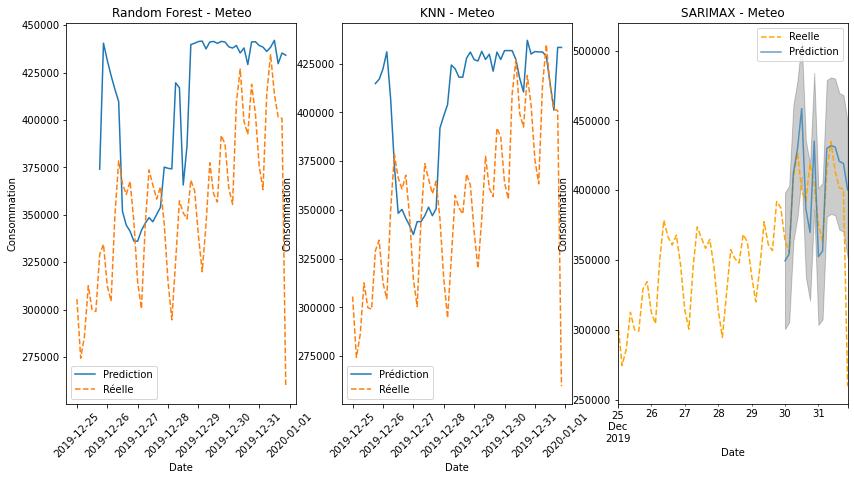

In [16]:
pred_sarima = sarimax.get_prediction(start=pd.to_datetime('2019-12-30', utc=True), dynamic=False)
pred_ci = pred_sarima.conf_int()

y_pred_rf = rf.predict(X_test_scaled)

y_pred_knn = knn.predict(X_test_scaled)

plt.figure(figsize=(25,25))
plt.subplot(131)
plt.plot(y_test.index, y_pred_rf, label='Prediction')
plt.title('Random Forest - Meteo')
plt.plot(conso['2019-12-25':], label='Réelle', linestyle='dashed')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(132)
plt.plot(y_test.index, y_pred_knn, label='Prédiction')
plt.plot(conso['2019-12-25':], label='Réelle', linestyle='dashed')
plt.title('KNN - Meteo')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Consommation')
plt.legend()

plt.subplot(133)
ax = conso['2019-12-25':].plot(label='Reelle', style='--', color='orange', title = 'SARIMAX - Meteo')
pred_sarima.predicted_mean.plot(ax=ax, label='Prédiction', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Consommation')
plt.legend()

plt.show()